**recsys-cluster-loss**

Exemplo de análise de agrupamento no contexto de sistemas de recomendação.
Os usuários que recebem as recomendações serão agrupados à partir da medida de justiça individual dessas recomendações.
Tem-se por objetivo analisar se existe algum tipo de injustiça de grupos não óbvios de usuários, ou seja, grupos que não possam ser configurados à partir de alguma característica (variável) explícita dos usuários (por exemplo: sexo, idade, etc.).

Serão aplicados dois métodos de agrupamento:
1. Agrupamento aglomerativo hierárquico (agrupamento em árvore - dendograma)
2. Agrupamento não-hierárquico por repartição (agrupamento por k-Médias)

Neste arquivo estamos analisando os possíveis agrupamentos considerando a(s) seguinte(s) variável(is):
- loss: injustiça individual
- age: age of users
- NA: number of evaluations performed for available items
- SPI: sum of the price of the items evaluated
- MA: average of item evaluation values
- MR: average of item recommendation values

Sistema de recomendação: gerando a matriz de recomendação e calculando a justiça individual

In [28]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

Cloning into 'recsys-cluster-loss'...


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [30]:
import sys
sys.path.append('recsys-cluster-loss/src')
from RecSys import RecSys
from UserFairness import IndividualLossVariance

In [31]:
# reading data from a base with 20 movies and 40 users
Data_path = 'recsys-cluster-loss/data/MovieLens-Small'
n_users=  40
n_movies= 20
top_users = False # True: to use users with more ratings; False: otherwise
top_movies = False # True: to use movies with more ratings; False: otherwise

In [32]:
# recommendation algorithm
algorithm = 'RecSysExampleAntidoteData20Items'

In [33]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [34]:
recsys = RecSys(n_users, n_movies, top_users, top_movies, l, theta, k)

In [35]:
X, genres, user_info = recsys.read_movieitems(n_users, n_movies, top_users, top_movies, Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [36]:
user_info

,Gender,Age,NA,SPI,MA,MR
1,M,20,12,530,2.08,2.38
2,F,24,12,570,3.00,2.75
3,M,30,11,600,3.18,2.89
4,F,17,10,550,2.50,2.90
5,M,51,10,500,3.60,3.20
6,F,47,10,550,2.70,3.30
7,M,41,10,500,2.50,2.70
8,F,38,10,550,3.30,2.60
9,M,21,10,500,3.40,3.20
10,F,18,10,550,3.00,2.80


In [37]:
X_est = recsys.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [38]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [39]:
df = pd.DataFrame(columns=['Gender', 'Age', 'NA', 'SPI', 'MA', 'MR', 'Loss'])
df['Loss'] = losses
df['Gender'] = user_info['Gender']
df['Age'] = user_info['Age']
df['NA'] = user_info['NA']
df['SPI'] = user_info['SPI']
df['MA'] = user_info['MA']
df['MR'] = user_info['MR']

df

,Gender,Age,NA,SPI,MA,MR,Loss
UserID,,,,,,,
1,M,20,12,530,2.08,2.38,1.000000
2,F,24,12,570,3.00,2.75,0.666667
3,M,30,11,600,3.18,2.89,4.181818
4,F,17,10,550,2.50,2.90,1.600000
5,M,51,10,500,3.60,3.20,3.900000
6,F,47,10,550,2.70,3.30,1.200000
7,M,41,10,500,2.50,2.70,1.800000
8,F,38,10,550,3.30,2.60,3.300000
9,M,21,10,500,3.40,3.20,3.400000


In [40]:
df.head()

,Gender,Age,NA,SPI,MA,MR,Loss
UserID,,,,,,,
1,M,20,12,530,2.08,2.38,1.000000
2,F,24,12,570,3.00,2.75,0.666667
3,M,30,11,600,3.18,2.89,4.181818
4,F,17,10,550,2.50,2.90,1.600000
5,M,51,10,500,3.60,3.20,3.900000


In [41]:
# Número de linhas e colunas:
df.shape

(40, 7)

In [42]:
# Estatística Descritiva:
df.describe()

,Age,NA,SPI,MA,MR,Loss
count,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000
mean,34.600000,10.125000,528.750000,3.01650,2.963000,3.801212
std,14.416515,0.463404,27.844578,0.42208,0.480231,1.823799
min,13.000000,10.000000,500.000000,2.08000,2.000000,0.666667
25%,22.000000,10.000000,500.000000,2.70000,2.600000,2.275000
50%,31.500000,10.000000,550.000000,3.00000,2.950000,3.900000
75%,43.250000,10.000000,550.000000,3.30000,3.300000,5.300000
max,69.000000,12.000000,600.000000,3.90000,4.000000,7.600000


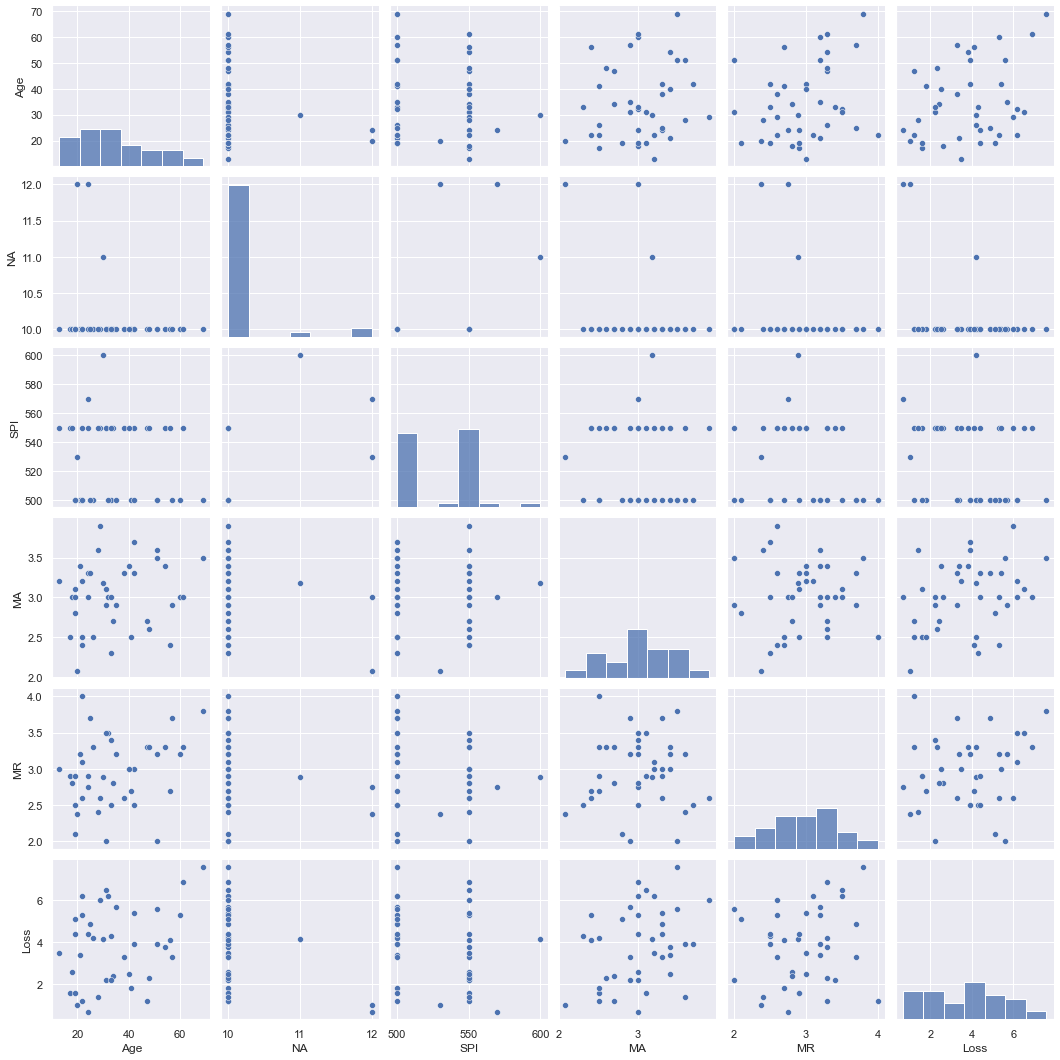

In [43]:
sns.pairplot(df)

<AxesSubplot:>

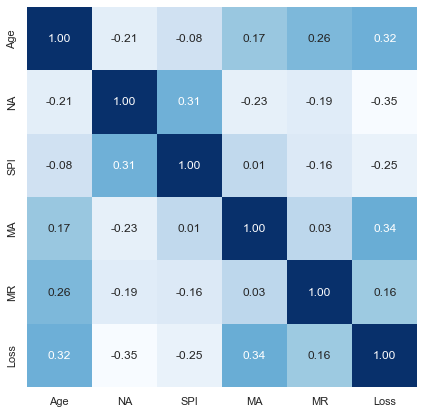

In [44]:
df2 = df.drop('Gender', 1) # Eliminando a coluna Gender (não numérica) para analisar as correlações

plt.figure(figsize=(7, 7))
corr = np.corrcoef(df2.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df2.columns, yticklabels=df2.columns)

Agrupamento aglomerativo hierárquico (agrupamento em árvore - dendograma)

In [45]:
# Deixando apenas a coluna loss para realizar a análise de agrupamento
#df2 = df2.drop('Age', 1) 
#df2 = df2.drop('NA', 1) 
#df2 = df2.drop('SPI', 1) 
#df2 = df2.drop('MA', 1) 
#df2 = df2.drop('MR', 1) 

In [46]:
df_scaled = df2.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df2)

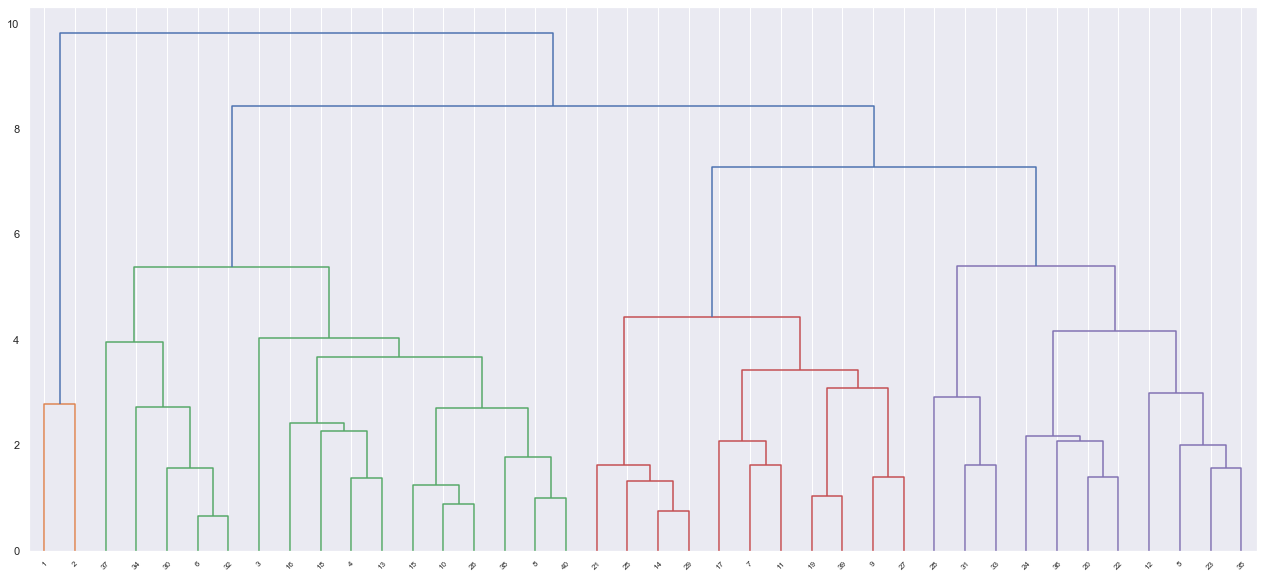

In [47]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [48]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
groups = cluster.fit_predict(df2)

In [49]:
groups

array([0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0], dtype=int64)

In [50]:

users = list(df2.index)
grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}')

Cluster 0: [1, 2, 3, 4, 6, 8, 10, 13, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]
Cluster 1: [7, 9, 11, 14, 17, 19, 21, 25, 27, 29, 31, 37, 39]
Cluster 2: [5, 12, 23, 33, 35]


Agrupamento não-hierárquico (K-médias)

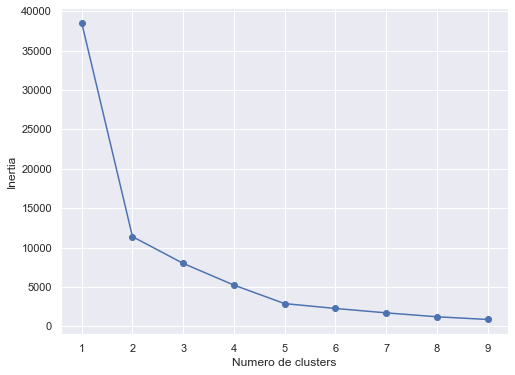

In [51]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df2)
    inertias.append(kmeans.inertia_)

# Plotando o gráfico do Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Numero de clusters')
plt.ylabel('Inertia');

In [52]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled)

In [53]:
df_scaled

,Age,NA,SPI,MA,MR,Loss,cluster
UserID,,,,,,,
1,-1.025629,4.097688,0.045464,-2.247039,-1.229465,-1.555488,2
2,-0.744635,4.097688,1.500310,-0.039590,-0.449187,-1.740585,2
3,-0.323143,1.912254,2.591445,0.392302,-0.153947,0.211347,0
4,-1.236375,-0.273179,0.772887,-1.239291,-0.132858,-1.222313,0
5,1.152076,-0.273179,-1.045671,1.400051,0.499800,0.054856,1
6,0.871082,-0.273179,0.772887,-0.759411,0.710686,-1.444430,0
7,0.449591,-0.273179,-1.045671,-1.239291,-0.554630,-1.111255,0
8,0.238845,-0.273179,0.772887,0.680230,-0.765516,-0.278319,0
9,-0.955380,-0.273179,-1.045671,0.920170,0.499800,-0.222789,0


In [54]:
users = list(df_scaled.index)
groups = df_scaled['cluster']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}')

Cluster 0: [3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 26, 27, 30, 32, 34, 37, 38, 39, 40]
Cluster 1: [5, 12, 14, 20, 21, 22, 23, 24, 25, 28, 29, 31, 33, 35, 36]
Cluster 2: [1, 2]
